In [44]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(42)
np.random.seed(42)


In [45]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output
from sklearn.datasets import make_moons

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [47]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/

# uses Real NVP paper

# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) #zeros?
        
        # takes the number of samples and returns a tensor of ones with the same size
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int,num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_hidden)
        ])
        
        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

        # Apply Xavier initialization to linear layers
        # for layer in self.hidden:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        #         nn.init.constant_(layer.bias, 0.001)

        # # Apply Xavier initialization to dims (output) layer
        # nn.init.xavier_uniform_(self.dims.weight)
        # nn.init.constant_(self.dims.bias, 0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        batch_params[:,:,1] *= 0.01
        batch_params[:,:,0] *= 0.01
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

In [48]:
# # Load make two moons dataset
# n_samples = 500
# noise = 0.05
# X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

# # Plot the dataset
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes[0].scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='r', label='Class 0')
# axes[0].scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b', label='Class 1')
# axes[0].set_xlabel('Feature 1')
# axes[0].set_ylabel('Feature 2')
# axes[0].legend()
# axes[0].set_title('Two Moons Dataset (Original)')

# # Preprocess the data (standardize)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# # Convert data to PyTorch tensor
# X_tensor = torch.FloatTensor(X)

# axes[1].scatter(X_tensor[y == 0][:, 0], X_tensor[y == 0][:, 1], color='r', label='Class 0')
# axes[1].scatter(X_tensor[y == 1][:, 0], X_tensor[y == 1][:, 1], color='b', label='Class 1')
# axes[1].set_xlabel('Feature 1 (Standardized)')
# axes[1].set_ylabel('Feature 2 (Standardized)')
# axes[1].legend()
# axes[1].set_title('Standardized Moons Dataset')
# plt.tight_layout()
# plt.show()

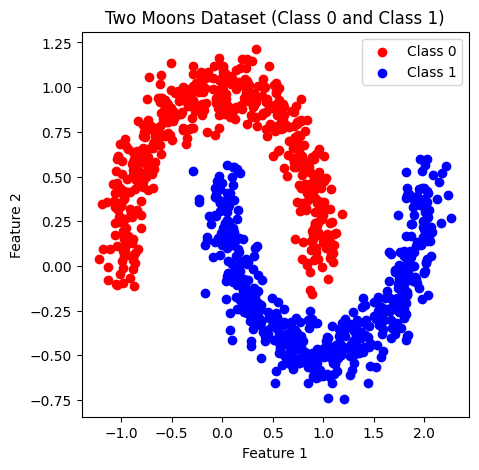

X_train shape:  torch.Size([1000, 2])
y_train shape:  (1000,)
Number of class 0 samples:  500
Number of class 1 samples:  500
X_train shape:  torch.Size([2, 500, 2])


In [49]:
# Data load
#------------------
#Make function that generates data for each class using below code
num_classes = 2
num_samples_per_class = 500
noise = 0.1
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
# X_train = []
# y_train = []
# for class_label in range(num_classes):
#     X_class, y_class = make_moons(n_samples=num_samples_per_class, noise=noise) #insert data generation function here
#     X_train.append(X_class)
#     y_train.append(y_class)
    #y_train.extend([class_label] * num_samples_per_class)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# Multi class standardisation - not that relevant for two moons
# scaler = StandardScaler()
# X_train = torch.stack([torch.FloatTensor(scaler.fit_transform(X_class)) for X_class in X_train])

# Plot the dataset
plt.figure(figsize=(5, 5))
colors = ['r', 'b']
for class_label in range(num_classes):
    plt.scatter(
        X_train[y_train == class_label][:, 0], 
        X_train[y_train == class_label][:, 1],
        color=colors[class_label],
        marker='o',
        label=f'Class {class_label}'
    )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Two Moons Dataset (Class 0 and Class 1)')
plt.show()
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
# Check how many are from class 0 and class 1
print("Number of class 0 samples: ", np.sum(y_train == 0))
print("Number of class 1 samples: ", np.sum(y_train == 1))

class0 = X_train[y_train == 0]
class1 = X_train[y_train == 1]
X_train = torch.stack((class0, class1))
print("X_train shape: ", X_train.shape)

In [50]:
num_classes = 2
num_samples_per_class = 500
noise = 0.1
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# scaler = StandardScaler()
# X_train = torch.stack( [torch.FloatTensor(scaler.fit_transform(X_class)) for X_class in X_train])

# Split the data into two classes
class0 = X_train[y_train == 0]
class1 = X_train[y_train == 1]
#concatenate the two classes
X_train = torch.stack((class0, class1))
X_train = X_train.to(device)
# class0 = class0.to(device)
# class1 = class1.to(device)  

data_dim = X_train.shape[-1] #equal 2, as is the last dimension of X_train
in_dim= 1#data_dim // 2 # since we split the data
out_dim= 1#data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers
lr = 0.003
weight_decay = 1e-6  # L2 regularization strength to prevent overfitting
num_epochs = 2000  # flere epochs

"""
# def coupling_flows(data_dim: int, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, 
#                    num_params: int, num_flows: int) -> List[nn.Module]:
#     flows = []
#     for _ in range(num_flows):
#         conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, 
#                                   hidden_dim=hidden_dim, num_params=num_params)
#         # def weights_init(m):
#         #      if isinstance(m, nn.Linear):
#         #          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#         # conditioner.apply(weights_init)  # Initialize weights
#         affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
#         flows.append(affine_coupling)
#     return flows
""" 
conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# def weights_init(m):
#      if isinstance(m, nn.Linear):
#          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
# conditioner.apply(weights_init)  # Initialize weights
affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
flows = [affine_coupling for _ in range(num_flows)]

# Define the latent distribution (Gaussian)
data_dim = 2
latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))
# Create the Normalizing Flow model for each class
#flow_models = []
#optimisers = []
# for class_label in range(num_classes):
#     flow_model = NormalizingFlow(latent_distribution, flows).to(device)
#     optimiser = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
#     flow_models.append(flow_model)
#     optimisers.append(optimiser)

flow_model_c0 = NormalizingFlow(latent_distribution, flows).to(device)
optimiser_c0 = torch.optim.Adam(flow_model_c0.parameters(), lr=lr, weight_decay=weight_decay)

conditioner1 = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# def weights_init(m):
#      if isinstance(m, nn.Linear):
#          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
# conditioner.apply(weights_init)  # Initialize weights
affine_coupling1 = AffineCouplingLayer(conditioner1, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
flows1 = [affine_coupling1 for _ in range(num_flows)]
flow_model_c1 = NormalizingFlow(latent_distribution, flows1).to(device)
optimiser_c1 = torch.optim.Adam(flow_model_c1.parameters(), lr=lr, weight_decay=weight_decay)

"""
# num_steps = len(train_loader)*num_epochs
# scheduler = StepLR(optimiser, step_size=args['lr_decay_interval'], gamma=args['lr_decay_rate'])

# Maybe save loss as a torch.zeros(len(train_loader)) where train_loader is the number of batches
# Maybe use log_interval = 50, meaning that we print the loss every 50 batches and take the mean of the losses

#args={'lr_decay_interval': 400, 'lr_decay_rate': .3, 'lr': 1e-3}

# def target_class(species: str) -> torch.Tensor:
#     x = iris[iris['Species'] == species].drop(columns='Species')
#     return torch.from_numpy(X.values).float()

#model_se, loss_se = train_with_args(target_class(classes[0]))
#model_ve, loss_ve = train_with_args(target_class(classes[1]))
"""

def train_flow_model(flow_model, optimiser, X_train, num_epochs, class_label):
    losses = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        optimiser.zero_grad()
        log_prob = flow_model.log_prob(X_train)
        loss = -torch.mean(log_prob)
        loss.backward()
        losses[epoch] = loss.item()
        optimiser.step()

        if (epoch + 1) % 100 == 0:
            print(f'Flow model {class_label} Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
    return losses, flow_model   

class_label = 0
losses_c0, flow_model_c0 = train_flow_model(flow_model_c0, optimiser_c0, X_train[class_label], num_epochs, class_label)

class_label = 1
losses_c1, flow_model_c1 = train_flow_model(flow_model_c1, optimiser_c1, X_train[class_label], num_epochs, class_label)
#all_losses = []
# for class_label in range(num_classes):
#     #Reset
#     print("class label",class_label)
#     losses = []
#     #flow_models[class_label].apply(weights_init)
#     losses, flow_model = train_flow_model(flow_models[class_label], optimisers[class_label], X_train[class_label], num_epochs)
#     all_losses.append(losses)
# plt.plot(losses[10:])
# plt.title("Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()

#Move X_train to cpu for further plots
#X_train = X_train.cpu().numpy()
#y_train = y_train.cpu().numpy()
#class0 = class0.to(device)
#class1 = class1.to(device)  

Flow model 0 Epoch [100/2000], Loss: 2.3486
Flow model 0 Epoch [200/2000], Loss: 2.3486
Flow model 0 Epoch [300/2000], Loss: 2.3486


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(losses_c0[10:])
axes[0].set_title("Losses class 0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].plot(losses_c1[10:])
axes[1].set_title("Losses class 1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

In [ ]:
# #X_train[0] == class0
# print(class0.shape)
# print(class1.shape)
# print(X_train[0].shape)
# print(X_train[1].shape)

# print("is equals?", np.array_equal(class0, X_train[0]))
# print(class0[0:4])
# print(X_train[0][0:4])
# #print how many indexes where they arent equal
# # differences = class0 != X_train[0]
# # num_differences = differences.sum().item()
# # print(f"Number of differences: {num_differences}")

# # are_equal = torch.equal(class0, X_train[0])
# # print(f"Are class0 and X_train[0] equal? {are_equal}")

# differences = class1 != X_train[1]
# num_differences = differences.sum().item()
# print(f"Number of differences: {num_differences}")
# print(f"Are class0 and X_train[0] equal?", torch.equal(class0, X_train[0]))
# print(f"Are class1 and X_train[1] equal?", torch.equal(class1, X_train[1]))

In [ ]:
X_train = X_train.cpu().numpy()
#class0 = class0.cpu().numpy()
#class1 = class1.cpu().numpy()

In [ ]:
# Generate samples from the trained models
num_samples_gen_per_class = 500
generated_samples = []
#class_label = 0 
with torch.no_grad():
    samples_c0 = flow_model_c0.sample(num_samples=num_samples_gen_per_class).cpu().numpy()
        #generated_samples.append(samples)

with torch.no_grad():
    samples_c1 = flow_model_c1.sample(num_samples=num_samples_gen_per_class).cpu().numpy()
# with torch.no_grad():
#     for class_label in range(num_classes):
#         samples = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()
#         generated_samples.append(samples)
#generated_samples = np.array(generated_samples)
#print("Generated samples shape: ", generated_samples.shape)

In [ ]:
# Check is samples_c0 are different from samples_c1
print("samples_c0 shape: ", samples_c0.shape)
print("samples_c1 shape: ", samples_c1.shape)
differences = samples_c0 != samples_c1
num_differences = differences.sum().item()
print(f"Number of differences: {num_differences}")

# plot samples_c0 and samples_c1
plt.figure(figsize=(8, 6))
plt.scatter(samples_c0[:, 0], samples_c0[:, 1], color='r', label='Generated Class 0')
plt.scatter(samples_c1[:, 0], samples_c1[:, 1], color='b', label='Generated Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Samples for Class 0 and Class 1')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(class0[:, 0], class0[:, 1], color='r', alpha=0.5, label='Class 0')
axes[0].scatter(samples_c0[:, 0], samples_c0[:, 1], color='b', alpha=0.5, label='Generated Class 0')
#axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='b', alpha=0.5, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(class1[:, 0], class1[:, 1], color='r', alpha=0.5, label='Class 1')
axes[1].scatter(samples_c1[:, 0], samples_c1[:, 1], color='b', alpha=0.5, label='Generated Class 1')
#axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='b', alpha=0.5, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(class0[:, 0], class0[:, 1], color='r', alpha=0.5, label='Class 0')
axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='b', alpha=0.5, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(class1[:, 0], class1[:, 1], color='r', alpha=0.5, label='Class 1')
axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='b', alpha=0.5, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

In [ ]:
# Color map for different classes
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
# Plot the original data points
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    plt.scatter(
        X_train[class_label, :, 0], 
        X_train[class_label, :, 1],
        color=colors[class_label],
        marker='o',
        label=f'Class {class_label}'
    )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Original Data and Generated Samples')
plt.show()

# Plot the generated samples
for class_label in range(num_classes):
    generated_samples_class = generated_samples[class_label]
    plt.scatter(
        generated_samples_class[:, 0], 
        generated_samples_class[:, 1],
        color=colors[class_label],
        marker='o',
        label=f'Generated Class {class_label}'
    )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Original Data and Generated Samples')
plt.show()

In [ ]:
# Plot the original data and the generated samples on top of each other
#class
c = 0
plt.scatter(X_train[c, :, 0], X_train[c, :, 1], label='Original Data', alpha=0.5)
plt.scatter(generated_samples[c, :, 0],generated_samples[c, :, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()

# Plot the original data and the generated samples in separate plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], s=10, label="Original Data")
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=10, label="Generated Samples")
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

# Plot function f from network in a grid
# use mesh grid
nx, ny = (100, 100)
x = np.linspace(5, 15, nx)
y = np.linspace(5, 15, ny)
xv, yv = np.meshgrid(x, y)

con = np.stack((xv.flatten(), yv.flatten()),axis=1)
#print(con.shape)
X_tensor2 = torch.FloatTensor(con).to(device)
print(X_tensor2.shape)

logprobs = flow_model.log_prob(X_tensor2)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
#make imshow size larger
plt.figure(figsize = (8,8))
plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])


#plot log_probs
# Plot the original data and the generated samples on top of each other

#plt.scatter(generated_samples[:, 0],generated_samples[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.07, color='red')
plt.legend()

In [ ]:
# Plot function f from network in a grid
# use mesh grid
nx, ny = (100, 100)
x = np.linspace(5, 15, nx)
y = np.linspace(5, 15, ny)
xv, yv = np.meshgrid(x, y)

con = np.stack((xv.flatten(), yv.flatten()),axis=1)
X_tensor2 = torch.FloatTensor(con).to(device)
logprobs = flow_model.log_prob(X_tensor2)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
plt.figure(figsize = (8,8))
plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

#plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.07, color='red')
plt.legend()
plt.show()
